# FUNCTIONS

In [1]:
def get_file_size(file_path):
  size = os.path.getsize(file_path)
  return size

In [2]:
def convert_bytes(size, unit=None):
  if unit == "KB":
    return print('File size: ' + str(round(size/1024,3)) + ' kilobytes')
  elif unit == "MB":
    return print('File size: ' + str(round(size/(1024*1024),3)) + ' Megabytes')
  else:
    return print('File size: ' + str(size) + ' bytes') 

# IMPORTING PACKAGES

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import tensorflow as tf


# DATA PREPROCESSING

In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
dataset=r'C:\Users\shubh\JUPYTER PROJECT\Untitled Folder\dataset'
imagePaths = list(paths.list_images(dataset))

In [16]:
data = []
labels = []

for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(128, 128))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


C:\Users\shubh\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [17]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


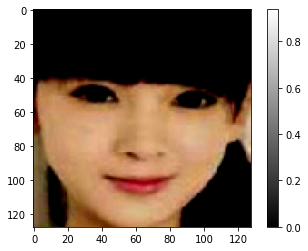

In [18]:
plt.figure()
plt.imshow(data[88],cmap="gray")
plt.colorbar()
plt.grid(False)
plt.show()

In [19]:
# partition the data into training and testing splits using 75% of 
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [20]:
len(data)

3897

In [21]:
trainX.shape

(3117, 128, 128, 3)

In [22]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15, width_shift_range=0.2, 
                         shear_range=0.15, horizontal_flip=True)

# MODEL

In [23]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(input_shape=(128,128,3),weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))

In [24]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [25]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [26]:
# compile our model
print("Compiling Model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling Model...


In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 16)   432         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 16)   64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 16)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [28]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
import time
start = time.time()
# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),
              validation_steps=len(testX) // BS,epochs=5)

print('\nTraining time required - {}'.format((time.time()-start)))

In [ ]:
# make predictions on the testing set
print("Evaluating Network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

In [ ]:
# serialize the model to disk
print("Saving mask detector model...")
model.load_weights(r'C:\Users\shubh\anaconda3\envs\PROJECT\FACEMASK DETECTION\model.h5',model)

In [ ]:
KERAS_MODEL_NAME='model.h5'

In [ ]:
convert_bytes(get_file_size(KERAS_MODEL_NAME),"MB")

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

In [ ]:
names = {0:'mask', 1:'No mask'}

In [ ]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations=[tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
#tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
#tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

In [ ]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")